In [5]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('../data_lake/business/precios-diarios.csv', parse_dates=['fecha'],
                 index_col=['fecha'])
df

,precio
fecha,
1995-07-20,1.409435
1995-07-21,4.924333
1995-07-22,1.269500
1995-07-23,0.953083
1995-07-24,4.305917
...,...
2021-04-26,188.325833
2021-04-27,181.770000
2021-04-28,175.874167


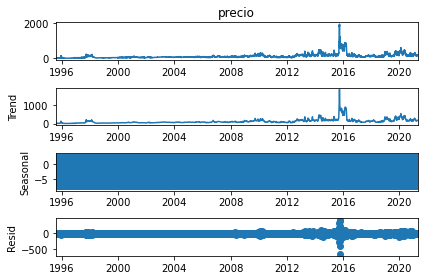

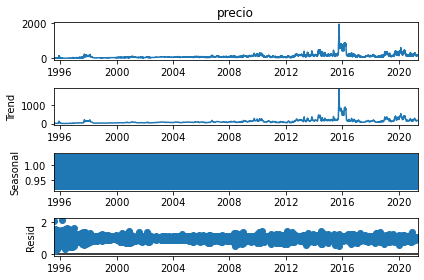

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df['precio'],model = 'add')
result_add.plot();
result_mul = seasonal_decompose(df['precio'],model = 'mul')
result_mul.plot();

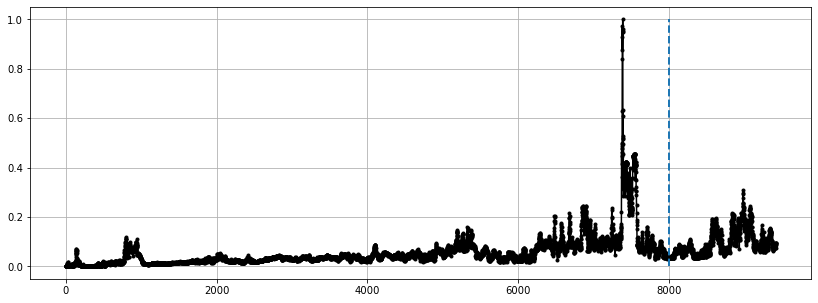

In [7]:
#
# Como primer paso se escala la serie al intervalo [0, 1]
# ya que esto facilita el entrenamiento del modelo
#
import numpy as np
from sklearn.preprocessing import MinMaxScaler

len_train_data = round(len(df)*0.85)
len_test_data = round(len(df)*0.15)

# crea el transformador
scaler = MinMaxScaler()

# escala la serie
data_scaled = scaler.fit_transform(np.array(df).reshape(-1, 1))

# z es un array de listas como efecto
# del escalamiento
data_scaled = [u[0] for u in data_scaled]

plt.figure(figsize=(14, 5))
plt.plot(data_scaled, ".-k")
plt.grid()
plt.plot(
    [len_train_data, len_train_data],
    [min(data_scaled), max(data_scaled)],
    "--",
    linewidth=2,
);

In [10]:
P = 30

X = []
for t in range(P - 1, len(df) - 1):
    X.append([data_scaled[t - n] for n in range(P)])

observed_scaled = data_scaled[P:]

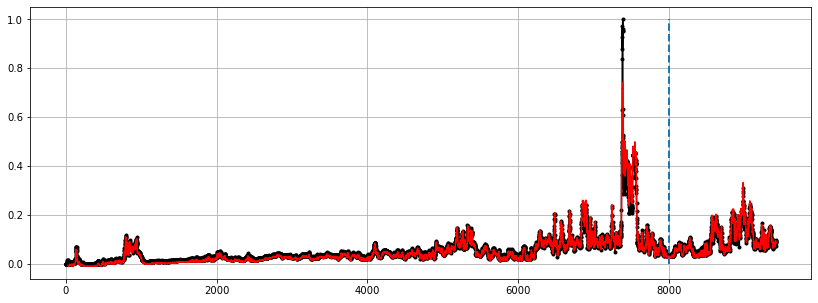

In [11]:
from sklearn.neural_network import MLPRegressor

np.random.seed(123456)

H = 1  # Se escoge arbitrariamente

mlp = MLPRegressor(
    hidden_layer_sizes=(H,),
    activation="logistic",
    learning_rate="adaptive",
    momentum=0.0,
    learning_rate_init=0.1,
    max_iter=10000,
)

# Entrenamiento
mlp.fit(X[0:len_train_data], observed_scaled[0:len_train_data])  # 239 - 24 = 215

# Pronostico
y_scaled_m1 = mlp.predict(X)

plt.figure(figsize=(14, 5))
plt.plot(data_scaled, ".-k")
plt.grid()

#
# No hay pronóstico para los primeros 13 valores
# de la serie
#
plt.plot([None] * P + y_scaled_m1.tolist(), "-r")

#
# linea vertical para dividir el entrenamiento
# del pronóstico. Se ubica en el ultimo dato
# usando para entrenamiento
#
plt.plot(
    [len_train_data, len_train_data],
    [min(data_scaled), max(data_scaled)],
    "--",
    linewidth=2,
);

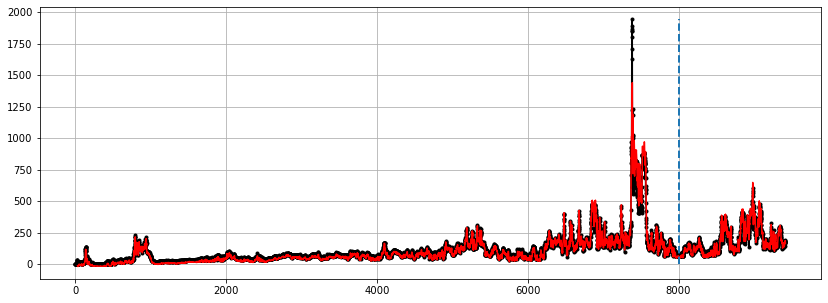

In [15]:
#
# Se desescala para llevar los valores a la escala de los datos originales
#
y_m1 = scaler.inverse_transform([[u] for u in y_scaled_m1])
y_m1 = [u[0] for u in y_m1]

plt.figure(figsize=(14, 5))
plt.plot(df.values, ".-k")
plt.grid()
plt.plot([None] * P + y_m1, "-r")
plt.plot([len_train_data, len_train_data], [min(df.values), max(df.values)], "--", linewidth=2);